In [27]:
from math import log, exp, sqrt, sin, cos, pi
import numpy
from numpy import split, array, arctan, mean, zeros, sin, cos, pi, arange, concatenate

import pandas as pd

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression

import tensorflow
from tensorflow.keras import backend as K
from tensorflow.keras.losses import MeanSquaredLogarithmicError
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LSTM
from tensorflow.python.keras.layers import RepeatVector, TimeDistributed, Bidirectional, Dropout

import matplotlib
from matplotlib import pyplot

pyplot.style.use('ggplot')

from IPython.display import Image 
import datetime, os

pyplot.rcParams['figure.dpi'] = 100
pyplot.rcParams['figure.figsize'] = [12,5]
matplotlib.rc('lines', linewidth=1, linestyle='-')

In [28]:
# MAAPE metric -> does not have the same behaviour as MAPE for actual values close to zero, which is good
def mean_arctangent_absolute_percentage_error(actual, predicted):
    return mean(arctan(abs((actual - predicted) / actual))) * 100

In [29]:
# train the model
def build_model(train, n_input, n_output, stride, units=32, epochs=50, batch_size=0):
    
    # prepare data
    train_x, train_y = to_supervised(train, n_input, n_output, stride)
    
    # Model variables
    verbose = 1 #batch_size 1 IS SGD, 1<BATCH_SIZE<SIZE IS MINIBATCH GD AND BATCH_SIZE=SIZE IS BATCH GD
    n_timesteps, n_features = train_x.shape[1], train_x.shape[2]
    
    # final data preparation for the model
    # reshape train_output into [samples, timesteps, features] for the LSTMs
    train_y = train_y.reshape(train_y.shape[0], train_y.shape[1], n_features)
    print(train_x.shape, train_y.shape)
    # define model
    model = Sequential()
    
    # VANILLA LSTM
    model.add(LSTM(units, activation='tanh', input_shape=(n_timesteps, n_features)))
    model.add((Dense(n_output)))
    
    model.compile(loss="mse", optimizer='adam', metrics=["mae"])  #Reminder: LOSS function is MSE but others can be used!
    
    early = tensorflow.keras.callbacks.EarlyStopping('loss', patience=5)

    # fit network
    history = model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose, callbacks=[early]) #tensorboard_callback,
    print(model.summary())
    pyplot.plot(history.history['loss'])
    pyplot.show()
    return model

In [30]:
# load the csv file
# ../old_data//30min/30minstore290.csv
# ../old_data/30min/30minstore1027.csv
# ../30min/30minstore274.csv
# special case01: ../old_data/30min/partial_covid_stationary_sliced_30minstore274.csv
# special case02: ../old_data/30min/full_covid_nonstationary_sliced_30minstore274.csv
# predict covid:  ../old_data/30min/predict_covid_30minstore274

# NEW STORES
# ../Treatment/imputed_stores/linear_interp_store0057.csv
# ../Treatment/new_stores/store_0057.csv

# ../Treatment/imputed_stores/linear_interp_store4969.csv
# ../Treatment/new_stores/store_4969.csv

# IMPUTED DATASET
dataset = pd.read_csv('../Treatment/imputed_stores/linear_interp_store0057.csv', header=0, infer_datetime_format=True,parse_dates=['ds'], index_col=['ds'])

print(dataset)

                     sales  n_clients imputed
ds                                           
2015-01-02 09:00:00  49.12       24.0     yes
2015-01-02 09:30:00  49.12       24.0     yes
2015-01-02 10:00:00  49.12       24.0      no
2015-01-02 10:30:00  42.00       22.0      no
2015-01-02 11:00:00  88.10       35.0      no
...                    ...        ...     ...
2019-07-23 19:00:00  63.23       21.0      no
2019-07-23 19:30:00  41.00       18.0      no
2019-07-23 20:00:00  39.00       22.0      no
2019-07-23 20:30:00  70.00       25.0      no
2019-07-23 21:00:00  59.00       28.0      no

[41225 rows x 3 columns]


In [31]:
# PARAMETERS
n_input = 25                 # steps used to predict (autoregressive order) p
n_output = 750               # steps to predict (forecast horizon) H
data_split = n_output        # to split the data in windows
stride = 1                   # stride value for the sliding window method (overlapped vs non-overlapped)
init_train_set = 725         # refers to when the train_set starts, this is useful for the sliding window method

# Univariate
dataset = dataset.iloc[init_train_set:]
dataset = dataset[['n_clients']]
n_features = len(dataset.columns)
print(dataset, n_features)

                     n_clients
ds                            
2015-01-31 09:00:00       10.0
2015-01-31 09:30:00       17.0
2015-01-31 10:00:00       32.0
2015-01-31 10:30:00       33.0
2015-01-31 11:00:00       38.0
...                        ...
2019-07-23 19:00:00       21.0
2019-07-23 19:30:00       18.0
2019-07-23 20:00:00       22.0
2019-07-23 20:30:00       25.0
2019-07-23 21:00:00       28.0

[40500 rows x 1 columns] 1


In [32]:
values = dataset.values

# ensure all data is float
values = values.astype('float32')

print(values.shape)

(40500, 1)


In [33]:
# split into train and test, leave the last test_set blocks for n_output timesteps
train = values

# Normalization
scaler = StandardScaler() #MinMaxScaler(feature_range=(0, 1)) 
train = scaler.fit_transform(train)

# restructure into windows, for the sliding window method
train = array(split(train, len(train) / data_split))
print(train.shape)

(54, 750, 1)


In [34]:
# convert history into inputs and outputs - framing to a supervised learning problem
def to_supervised(train, n_input, n_output, stride=1):
    # flatten data
    data = train.reshape(train.shape[0] * train.shape[1], train.shape[2])
    train_x, train_y = list(), list()
    in_start = 0
    # step over the entire history one STRIDE step at a time
    for _ in range(0, len(data), stride):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_output
        # ensure we have enough data for this instance
        if out_end <= len(data):
            #print("iteration")
            #print(_)
            #print("x")
            #print(in_start,in_end)
            #print("y")
            #print(in_end,out_end)
            train_x.append(data[in_start:in_end, :])
            train_y.append(data[in_end:out_end, 0])
        # move along stride time steps
        in_start += stride
    #print(array(train_x).shape, array(train_y).shape)
    return array(train_x), array(train_y)

In [35]:
# make the multi-step forecast
def forecast(model, history, n_input):
    # flatten data
    data = array(history)
    data = data.reshape((data.shape[0] * data.shape[1], data.shape[2]))
    
    # retrieve last n_input observations to predict with
    input_x = data[-n_input:, :]
    
    # reshape into [1, n_input, n]
    input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))
    
    # forecast the next n_output steps
    yhat = model.predict(input_x, verbose=0)
    
    # we only want the forecast variable
    yhat = yhat[0]
    return yhat

In [36]:
# invert the scaling
def invTransformTarget(scaler, data):
    dummy = pd.DataFrame(zeros((len(data), scaler.n_features_in_)))
    dummy[0] = data
    dummy = pd.DataFrame(scaler.inverse_transform(dummy), columns=dummy.columns)
    return dummy[0].values

(39726, 25, 1) (39726, 750, 1)
Epoch 1/50
1242/1242 [==============================] - 9s 7ms/step - loss: 0.5018 - mae: 0.5413
Epoch 2/50
1242/1242 [==============================] - 8s 6ms/step - loss: 0.3289 - mae: 0.4199
Epoch 3/50
1242/1242 [==============================] - 8s 6ms/step - loss: 0.3205 - mae: 0.4137
Epoch 4/50
1242/1242 [==============================] - 8s 6ms/step - loss: 0.3157 - mae: 0.4098
Epoch 5/50
1242/1242 [==============================] - 8s 6ms/step - loss: 0.3114 - mae: 0.4068
Epoch 6/50
1242/1242 [==============================] - 8s 6ms/step - loss: 0.3101 - mae: 0.4057
Epoch 7/50
1242/1242 [==============================] - 8s 6ms/step - loss: 0.3086 - mae: 0.4044
Epoch 8/50
1242/1242 [==============================] - 8s 6ms/step - loss: 0.3073 - mae: 0.4032
Epoch 9/50
1242/1242 [==============================] - 8s 6ms/step - loss: 0.3060 - mae: 0.4022
Epoch 10/50
1242/1242 [==============================] - 8s 6ms/step - loss: 0.3051 - mae: 0.401

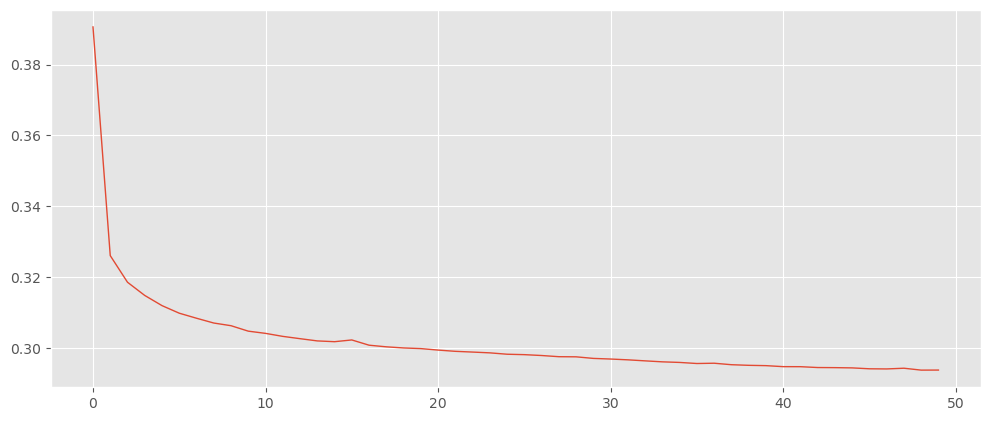

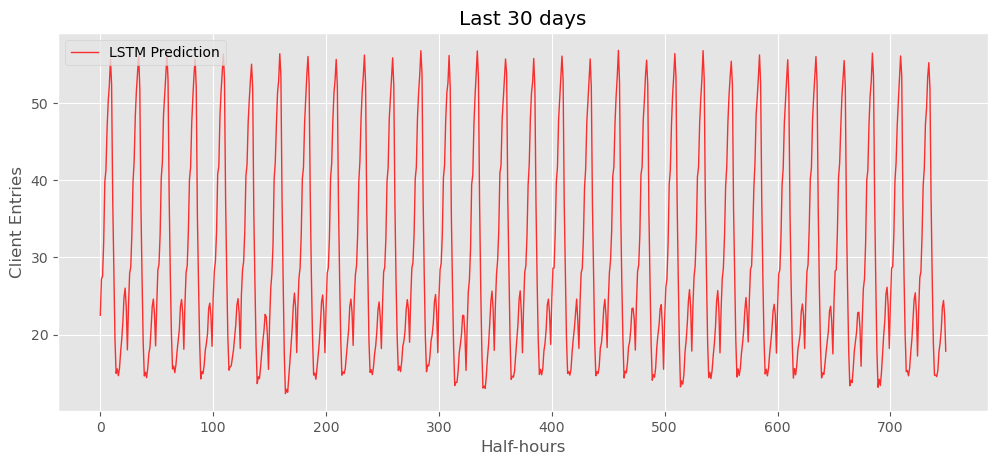

In [37]:
# history of windows, is updated for each prediction
history = [x for x in train]

# the model is trained and retrained for every number of n_output to predict
model = build_model(array(history), n_input, n_output, stride)  
train_size = len(history) # number of training windows
len_train = train_size*n_output # actual training size/length
            
# predict the next n_output steps
yhat_sequence = forecast(model, history, n_input)
    
# invert the scaling on predictions
yhat_sequence = invTransformTarget(scaler, yhat_sequence)
    
# plot results
pyplot.title('Last 30 days')
pyplot.plot(yhat_sequence, alpha=0.8, color="red", label="LSTM Prediction")
pyplot.legend(loc="upper left")
pyplot.xlabel("Half-hours")
pyplot.ylabel("Client Entries")
pyplot.show()